### Generic Imports

In [1]:
import scipy.signal
from IPython.display import Audio, display
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
import random
import sklearn.preprocessing
import norbert
import musdb
import torch
import os

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

from use_openunmix import SlakhDataset

Initialize the dataset

In [ ]:
if os.path.abspath(os.getcwd()) == '/home/olaf/Documents/GitHub/ddspzart/ws_2/open-unmix-pytorch':
    %cd ../source_seperation/
%pwd

train_dataset = SlakhDataset(seq_duration=5.0)

In [ ]:
train_dataset.filter_target()
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

x = train_dataset.targets[31].get_total_audio()
display(Audio(x, rate=44100*4))
x = train_dataset.targets[32].get_total_audio()
display(Audio(x, rate=44100*4))

In [ ]:
%cd ../open-unmix-pytorch/
%pwd

torch.Size([2, 220500])
torch.Size([1, 1, 2049, 212])


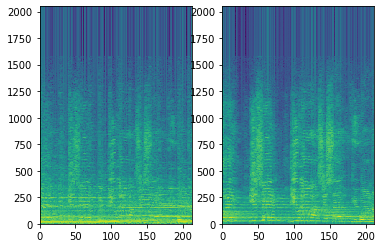

In [21]:
import openunmix

import torch.nn as nn

# create a spectrogram layer
stft = openunmix.transforms.TorchSTFT() # -> shape (nb_samples, nb_channels, nb_bins, nb_frames, complex=2)
spec = openunmix.transforms.ComplexNorm(mono=True) # -> shape (nb_samples, nb_channels(=1 if mono), nb_bins, nb_frames)
transform = nn.Sequential(stft, spec)

x, y = train_dataset[60]
print(x.shape)

# transform the time domain input to spectrograms
X = transform(x[None])
Y = transform(y[None])
print(X.shape)

f, axes = plt.subplots(1, 2)
axes[0].pcolormesh(np.log(X[0, 0, :, :].detach().numpy() ))
axes[1].pcolormesh(np.log(Y[0, 0, :, :].detach().numpy() ))

display(Audio(x, rate=44100))
display(Audio(y, rate=44100))


## Compute global mean and scale of Dataset

Sample from the dataset and update mean standard deviation using scikit-learn `StandardScaler`.

In [22]:

scaler = sklearn.preprocessing.StandardScaler()

for x, y in tqdm.notebook.tqdm(train_dataset):
    X = transform(x[None]).T
    scaler.partial_fit(X.squeeze().numpy())
print(X.shape, X.T.shape)

# set inital input scaler values
scale = np.maximum(
    scaler.scale_,
    1e-4*np.max(scaler.scale_)
)
mean = scaler.mean_

  0%|          | 0/80 [00:00<?, ?it/s]

/home/olaf/Documents/GitHub/ddspzart/ws_2/.openunmix_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  after removing the cwd from sys.path.


torch.Size([212, 2049, 1, 1]) torch.Size([1, 1, 2049, 212])


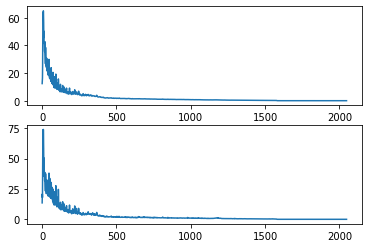

In [23]:
f, axes = plt.subplots(2, 1)
axes[0].plot(mean)
axes[1].plot(scale)


## Set up the model

In [24]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Train a model 

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="../source_seperation/runs/exp1")

In [ ]:

losses = openunmix.utils.AverageMeter()
unmix.train()
stft = openunmix.transforms.TorchSTFT() 
spec = openunmix.transforms.ComplexNorm(mono=True)
transform = nn.Sequential(stft, spec).to(device)

for epoch in tqdm.notebook.tqdm(range(50)):
    for x, y in tqdm.notebook.tqdm(train_sampler):
    #for x, y in train_sampler:   
        x, y = x.to(device), y.to(device)
        X = transform(x)
        Y = transform(y)
        optimizer.zero_grad()
        Y_hat = unmix(X)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        loss.backward()
        optimizer.step()
        losses.update(loss.item(), Y.size(1))
    writer.add_scalar("Loss/train", losses.avg, epoch)
    print(f"{losses.avg:.3f}")

writer.flush()
writer.close()

In [ ]:
f, axes = plt.subplots(1, 3)
axes[0].pcolormesh(np.log(X[0, 0, :, :].detach().cpu().numpy() ))
axes[1].pcolormesh(np.log(Y[0, 0, :, :].detach().cpu().numpy() ))
axes[2].pcolormesh(np.log(Y_hat[0, 0, :, :].detach().cpu().numpy() ))

In [ ]:
# Define own separator
track = train_dataset[0]

print(track[0][None,...].shape)
audio_torch = track[0][None,...].float().to(device)
print(audio_torch)
target_models = {"French horn": unmix}
own_seperator = openunmix.model.Separator(target_models,nb_channels=1).to(device)
#y = torch.tensor(track[1][None,...]).float().to(device).clone().detach().squeeze()
y = track[1][None,...].float().to(device).squeeze()
print(y)
y_hat = own_seperator.forward(audio_torch).clone().detach().squeeze()
print(y_hat)
display(Audio(track[0], rate=44100))
display(Audio(y.cpu().numpy(), rate=44100))
display(Audio(y_hat.cpu().numpy(), rate=44100))


## Synthesize



In [ ]:
device = "cpu"
track = train_dataset[0]
print(track[0][None,...].shape)
audio_torch = track[0][None,...].float().to(device)
print(audio_torch.shape)

In [ ]:
# Define own separator
target_models = {"vocals": unmix}
own_seperator = openunmix.model.Separator(target_models,nb_channels=1)
audio_torch = torch.tensor(track.audio.T[None, ...]).float().to(device)
print(audio_torch.shape)
own_seperator.forward(audio_torch)

In [ ]:
separator = openunmix.umxl()

In [ ]:
unmix_vocals = separator.target_models["vocals"].to(device)
# Define own separator
target_models = {"vocals": unmix_vocals}
own_seperator = openunmix.model.Separator(target_models,nb_channels=1)
own_seperator.forward(audio_torch)

In [ ]:
estimates = separator(audio_torch)
estimates.shape

In [ ]:
x = openunmix.predict.separate(audio_torch, rate=44_100 ,separator=own_seperator)

# MUSDB training
-> Also not really effective...

In [26]:
import musdb
from use_openunmix import SimpleMUSDBDataset
train_dataset = SimpleMUSDBDataset(seq_duration=5.0)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
print(len(train_dataset))

80


In [27]:
scaler = sklearn.preprocessing.StandardScaler()

for x, y in tqdm.notebook.tqdm(train_dataset):
    X = transform(x[None]).T
    scaler.partial_fit(X.squeeze().numpy())

# set inital input scaler values
scale = np.maximum(
    scaler.scale_,
    1e-4*np.max(scaler.scale_)
)
mean = scaler.mean_

  0%|          | 0/80 [00:00<?, ?it/s]

In [30]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

#device = "cpu"

In [31]:
import torch.optim as optim

unmix = openunmix.model.OpenUnmix(
    input_mean=mean,
    input_scale=scale,
    nb_channels=1,
    hidden_size=512,
    max_bin=512,
    nb_bins=2048+1
).to(device)
    
optimizer = optim.RMSprop(unmix.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [32]:

losses = openunmix.utils.AverageMeter()
unmix.train()

for i in tqdm.notebook.tqdm(range(15)):
    for x, y in tqdm.notebook.tqdm(train_sampler):
        x, y = x.to(device), y.to(device)
        X = transform(x)
        Y = transform(y)
        optimizer.zero_grad()
        Y_hat = unmix(X)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        loss.backward()
        optimizer.step()
        losses.update(loss.item(), Y.size(1))
    print(losses.avg)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

58.50587692260742


  0%|          | 0/20 [00:00<?, ?it/s]

44.83989067077637


  0%|          | 0/20 [00:00<?, ?it/s]

38.38695262273153


  0%|          | 0/20 [00:00<?, ?it/s]

34.470086777210234


  0%|          | 0/20 [00:00<?, ?it/s]

31.433234014511108


  0%|          | 0/20 [00:00<?, ?it/s]

29.104032921791077


  0%|          | 0/20 [00:00<?, ?it/s]

27.365278809411183


  0%|          | 0/20 [00:00<?, ?it/s]

25.753012120723724


  0%|          | 0/20 [00:00<?, ?it/s]

24.389038128323026


  0%|          | 0/20 [00:00<?, ?it/s]

23.1695733499527


  0%|          | 0/20 [00:00<?, ?it/s]

22.143035377155652


  0%|          | 0/20 [00:00<?, ?it/s]

21.310426213343938


  0%|          | 0/20 [00:00<?, ?it/s]

20.469665120198176


  0%|          | 0/20 [00:00<?, ?it/s]

19.741624695914133


  0%|          | 0/20 [00:00<?, ?it/s]

19.06492395401001


In [37]:
import musdb
mus = musdb.DB(download=True, subsets='test')
track = mus[1]

# Define own separator
target_models = {"vocals": unmix}
own_seperator = openunmix.model.Separator(target_models,nb_channels=1).to(device)
audio_torch = torch.tensor(track.audio.T[None, ...]).float().to(device)
print("audio",audio_torch.shape)
y_hat = own_seperator.forward(audio_torch).clone().detach().squeeze()
print("y_hat",y_hat)
#print("y",y)
#torch.mean((y_hat-y)**2)

#display(Audio(y.cpu().numpy(), rate=44100))
display(Audio(y_hat.cpu().numpy(), rate=44100))



audio torch.Size([1, 2, 300032])
y_hat tensor([[-0.0141, -0.0188, -0.0097,  ..., -0.0136, -0.0208, -0.0316],
        [ 0.0800,  0.0814,  0.0701,  ...,  0.0026,  0.0138,  0.0204]])


In [38]:
if os.path.abspath(os.getcwd()) == '/home/olaf/Documents/GitHub/ddspzart/ws_2/open-unmix-pytorch':
    %cd ../source_seperation/
%pwd

train_dataset = SlakhDataset(seq_duration=5.0)

  0%|          | 0/1289 [00:00<?, ?it/s]

In [44]:
track = train_dataset[0]
print(track[1][None,...].shape)
print(track[1][:10])

# Define own separator
target_models = {"vocals": unmix}
own_seperator = openunmix.model.Separator(target_models,nb_channels=1).to(device)
audio_torch = torch.tensor(track[0][None,...]).float().to(device)
y = torch.tensor(track[1][None,...]).float().to(device).squeeze()
print("audio",audio_torch.shape)
y_hat = own_seperator.forward(audio_torch).clone().detach().squeeze()
print("y_hat",y_hat)
print("y",y)
torch.mean((y_hat-y)**2)

display(Audio(y.cpu().numpy(), rate=44100))
display(Audio(y_hat.cpu().numpy(), rate=44100))

torch.Size([1, 1, 220500])
tensor([[0.0268, 0.0236, 0.0203,  ..., 0.0755, 0.0764, 0.0771]])
audio torch.Size([1, 1, 220500])
y_hat tensor([ 0.1135,  0.1113,  0.1074,  ...,  0.0026, -0.0049, -0.0127])
y tensor([0.0268, 0.0236, 0.0203,  ..., 0.0755, 0.0764, 0.0771])


/home/olaf/Documents/GitHub/ddspzart/ws_2/.openunmix_venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/olaf/Documents/GitHub/ddspzart/ws_2/.openunmix_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":
